In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

In [6]:
#Reverse the data
data = pd.read_csv('data.csv').iloc[::-1].reset_index(drop=True)
data.dropna(inplace=True)

In [7]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.drop(columns=['timestamp']).values, dtype=torch.float32)
    def __len__(self):
        return len(self.data)-25
    def __getitem__(self, idx):
        x = self.data[idx:idx+25, :]
        y = self.data[idx+25, list(range(0, 80, 5))]
        return x, y
dataset = MyDataset(data)        

In [8]:
x,_=dataset[1]
x.size()

torch.Size([25, 130])

In [9]:
#Split the data
train_set, val_set = torch.utils.data.random_split(dataset, [0.8,0.2])
val_load = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
train_load = DataLoader(train_set, batch_size=64, shuffle=True)
x_val, y_val = next(iter(val_load))

In [92]:
#Batch first positional encoding
class position_encoding(nn.Module):
    def __init__(self, d_model, max_len=25):
        super(position_encoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model).to('cuda')
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to('cuda')
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)).to('cuda')
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.pe = pe
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [93]:
class attention_model(nn.Module):
    def __init__(self):
        super(attention_model, self).__init__()
        self.bn1 = nn.BatchNorm1d(25)
        self.position_encoder = position_encoding(130)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=130, nhead=5,batch_first=True)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=2)
        self.fc = nn.Linear(3250, 17)
    def forward(self, x):
        x = self.bn1(x)
        x = self.position_encoder(x)
        x = self.decoder(x,x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

# FILEPATH: /e:/onedrive/OneDrive - connect.hku.hk/桌面/JP/AI/Public/model.ipynb
model1 = attention_model().to('cuda')

In [94]:
def loss_func(x, y_pred, y_true):
    split = F.softmax(y_pred, dim=1)
    x_value = x[:, 24, list(range(0, 80, 5))]
    ratio = y_true/x_value
    gain = torch.mean((ratio * split[:,:-1]).sum(dim=1))
    return -gain

In [95]:
x_val = x_val.to('cuda')
y_val = y_val.to('cuda')
@torch.no_grad()
def val_loss():
    model1.eval()
    preds = model1(x_val)
    model1.train()
    return loss_func(x_val, preds, y_val).item()

In [96]:
optimizer = optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [97]:
def train_one_epoch(epoch):
    model1.train()
    total_loss = 0
    for i in train_load:
        model1.train()
        optimizer.zero_grad()
        features, targets = i
        features=features.to('cuda')
        targets=targets.to('cuda')
        preds = model1(features)
        loss = loss_func(features, preds, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*features.shape[0]
    scheduler.step(val_loss())
    val=float(val_loss())
    return f"loss: {total_loss / len(train_set)}\n val_loss: {val}\n"

In [99]:
for epoch in range(50):
    print('epoch:', epoch)
    print(train_one_epoch(epoch))

epoch: 0
loss: -1.0007737317392904
 val_loss: -1.0007658004760742

epoch: 1
loss: -1.0012123180973915
 val_loss: -1.0007656812667847

epoch: 2
loss: -1.0008700105451769
 val_loss: -1.0007656812667847

epoch: 3
loss: -0.9954043376830316
 val_loss: -1.0037552118301392

epoch: 4
loss: -1.0018711878407387
 val_loss: -1.0037552118301392

epoch: 5
loss: -1.0018730086665
 val_loss: -1.0037552118301392

epoch: 6
loss: -1.0018711782270862
 val_loss: -1.0037552118301392

epoch: 7
loss: -1.0018377746305158
 val_loss: -1.0037552118301392

epoch: 8
loss: -1.001869386242282
 val_loss: -1.0037550926208496

epoch: 9
loss: -1.0018344002385293
 val_loss: -1.0037552118301392

epoch: 10
loss: -1.0018711897634691
 val_loss: -1.0037552118301392

epoch: 11
loss: -1.00186715972039
 val_loss: -1.0037550926208496

epoch: 12
loss: -1.0018434889854924
 val_loss: -1.0037552118301392

epoch: 13
loss: -1.000388628052127
 val_loss: -1.0014594793319702

epoch: 14
loss: -0.941154946002268
 val_loss: -1.0014594793319702

In [104]:
def analyze_year(year):
    data_year = data[(data['timestamp']>f'{year}-01-01') & (data['timestamp']<f'{year+1}-01-01')]
    data_year = MyDataset(data_year)
    data_year = DataLoader(data_year, batch_size=len(data_year), shuffle=False)
    x_year, y_year = next(iter(data_year))
    x_year = x_year.to('cuda')
    y_year = y_year.to('cuda')
    model1.eval()
    y_pred = model1(x_year)
    split = F.softmax(y_pred, dim=1)
    x_value = x_year[:, 24, list(range(0, 80, 5))]
    ratio = y_year/x_value
    gains = list((ratio * split[:,:-1]).sum(dim=1).cpu().tolist())
    asset = [1]
    for i in range(len(gains)):
        asset.append(asset[-1]*gains[i])
    return asset, gains

In [105]:
import matplotlib.pyplot as plt

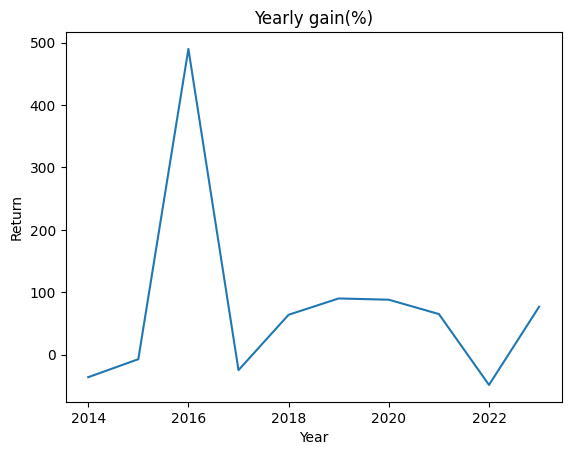

In [114]:
yearly_gain = []
for year in range(2014,2024):
    asset, gains = analyze_year(year)
    yearly_gain.append((asset[-1]-1)*100)
year = list(range(2014,2024))
plt.plot(year, yearly_gain)
plt.title(f'Yearly gain(%)')
plt.xlabel('Year')
plt.ylabel('Return')
plt.show()